In [160]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
from copy import copy
import seaborn as sns
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

from utils.conn_data import load_pickle

In [ ]:
dataset_name = 'monetary-policy-processed' # 'etfs_macro_large'

outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

# des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods_tags = {
    "seqICP_nocluster": "SeqICP",
    "pcmci_nocluster": "PCMCI",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "multivariate-granger_nocluster": "Multivariate Granger",
    "dynotears_nocluster": "Dynotears",
    "var-lingam_nocluster": "VAR-LiNGAM",
    "sfscv-forward-lin_nocluster": "SFSCV F Lin",
    "sfscv-backward-lin_nocluster": "SFSCV B Lin",
    "sfscv-forward-svm_nocluster": "SFSCV F SVM",
    "sfscv-backward-svm_nocluster": "SFSCV B SVM",
    "sfscv-forward-rf_nocluster": "SFSCV F RF",
    "sfscv-backward-rf_nocluster": "SFSCV B RF",
    "sfstscv-forward-lin_nocluster": "SFSTSCV F Lin",
    "sfstscv-backward-lin_nocluster": "SFSTSCV B Lin",
    "sfstscv-forward-svm_nocluster": "SFSTSCV F SVM",
    "sfstscv-backward-svm_nocluster": "SFSTSCV B SVM",
    "sfstscv-forward-rf_nocluster": "SFSTSCV F RF",
    "sfstscv-backward-rf_nocluster": "SFSTSCV B RF",

}

fs_methods = [
    "seqICP_nocluster",
    "pcmci_nocluster",
    "dynotears_nocluster", 
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
    "var-lingam_nocluster",
    "sfscv-forward-lin_nocluster",
    "sfscv-backward-lin_nocluster",
    "sfscv-forward-svm_nocluster",
    "sfscv-backward-svm_nocluster",
    "sfscv-forward-rf_nocluster",
    "sfscv-backward-rf_nocluster",
    "sfstscv-forward-lin_nocluster",
    "sfstscv-backward-lin_nocluster",
    "sfstscv-forward-svm_nocluster",
    "sfstscv-backward-svm_nocluster",
    "sfstscv-forward-rf_nocluster",
    "sfstscv-backward-rf_nocluster"
]

# fs_methods = [
#     "seqICP_nocluster",
#     "pcmci_nocluster",
#     "dynotears_nocluster", 
#     "pairwise-granger_nocluster",
#     "var-lingam_nocluster",
#     "sfscv-backward-svm_nocluster",
# ]

# etfs = [
#     "SPY"
# ]

event_dates = [
    ("GFC", ("2008-09-01", "2008-11-01")),
    ("Eurozone Debt Crisis", ("2010-05-01", "2012-07-01")),
    ("Swiss Franc Peg Announcement", ("2011-07-01", "2011-09-01")),
    ("Swiss Franc Peg Removal", ("2014-12-01", "2015-02-01")),
    ("COVID-19", ("2020-01-01", "2020-04-01"))
]

# event_dates = [
#     ("GFC", ("2007-07-01", "2008-11-01")),
#     ("Dow Jones Flash Crash", ("2010-03-01", "2010-07-01")),
#     ("Tsunami Fukushima", ("2011-01-01", "2011-05-01")),
#     ("Black Monday 2011", ("2011-06-01", "2011-10-01")),
#     ("Chinese Black Monday", ("2015-06-01", "2015-10-01")),
#     ("Dow Jones Plunge 2018", ("2018-01-01", "2018-05-01")),
#     ("COVID-19", ("2020-01-01", "2020-05-01"))
# ]

metric_names = ["r2-oos", "rmse"]
etf_focus = None
stability_threshold = 0.8   
plot_ts = False

In [75]:
warnings.simplefilter("ignore")

all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:
    # print(fs)

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, dataset_name, "*.pickle"))

    if len(results_files) == 0:
        print(f"No results files found for {fs}")
        continue

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        # if etf not in etfs:
        #     continue
        # else:
        #     pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions'].loc["2006-01-01":]

        # filter predictions
        predictions_df.loc[(predictions_df['prediction_zscore'] == 1)|(predictions_df['prediction_zscore'] == -1), 'prediction_zscore'] = 0
        predictions_df.loc[(predictions_df['prediction'] == 1)|(predictions_df['prediction'] == -1), 'prediction'] = 0
        
        # Dictionary to hold the data subsets for each event
        crisis_predictions = []

        # Loop through the event_dates list, subset the DataFrame, and store each subset in the dictionary
        for event_name, (start_date, end_date) in event_dates:
            # Subset the DataFrame within the specified date range
            subset_df = predictions_df.loc[start_date:end_date]
            # Store the subset DataFrame in the dictionary with the event name as the key
            crisis_predictions.append(subset_df)

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling metrics
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = ((rolling_metric_df["true"]  - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean()
        rolling_metric_df["rolling_mae"] = (abs(rolling_metric_df["true"] - rolling_metric_df["prediction"])).rolling(window=12).mean()
        rolling_metric_df["rolling_rmse"] = np.sqrt(((rolling_metric_df["true"] - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean())
        rolling_metric_df["rolling_r2-oos"] = pd.Series(r2_score(rolling_metric_df["true"], rolling_metric_df["prediction"])).rolling(window=12).mean()
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_mae", "rolling_rmse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        rmse = np.sqrt(mean_squared_error(predictions_df["true"], predictions_df["prediction"]))
        r2oos = r2_score(predictions_df["true"], predictions_df["prediction"])

        crisis_predictions_df = pd.concat(crisis_predictions)
        crisis_mse = mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"])
        crisis_mae = mean_absolute_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"])
        crisis_rmse = np.sqrt(mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]))
        crisis_r2oos = r2_score(crisis_predictions_df["true"], crisis_predictions_df["prediction"])

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # add tags
        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        # fill na of clusters column
        if "nocluster" in fs:
            parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
        elif ("pca" in fs):
            codes, uniques = pd.factorize(parents_of_target_df['fred'])
            parents_of_target_df['cluster'] = codes         
        else:
            parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

        all_parents.append(parents_of_target_df)

        metrics_df = pd.DataFrame({
            "fs": fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs, 
            "etf": etf, 
            # "mse": [mse],
            # "mae": [mae], 
            "rmse": [rmse],
            "r2-oos": [r2oos],
            # "mse_crisis": [crisis_mse], 
            # "mae_crisis": [crisis_mae],
            "rmse_crisis": [crisis_rmse],
            "r2-oos_crisis": [crisis_r2oos]})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Debugging

In [76]:
# fs = "seqICP_nocluster"

# # list results files with glob
# results_files = glob.glob(os.path.join(outputs_path, fs, "monetary-policy-processed", "*.pickle"))

# file = next(iter(results_files))
# etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

# print(f"{file}")

# obj = load_pickle(path=file)

# # compute cluster stability metrics
# parents_of_target_df = obj["parents_of_target"]

# # # add tags
# # parents_of_target_df["etf"] = etf
# # parents_of_target_df["fs"] = fs

# # # fill na of clusters column
# # if "nocluster" in fs:
# #     parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
# # elif ("pca" in fs):
# #     codes, uniques = pd.factorize(parents_of_target_df['fred'])
# #     parents_of_target_df['cluster'] = codes         
# # else:
# #     parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

# # all_parents.append(parents_of_target_df)

In [77]:
# parents_of_target_df

## Table with summary statistics

In [78]:
melted_all_metrics_df["crisis"] = [val.split("_")[-1] if len(val.split("_")) > 1 else "nocrisis" for val in melted_all_metrics_df["variable"] ]
melted_all_metrics_df["variable"] = [val.split("_")[0] for val in melted_all_metrics_df["variable"] ]

In [82]:
pivot_df = melted_all_metrics_df.pivot_table(
    index=['fs'], 
    columns=['variable', 'crisis'], 
    values='value',
    aggfunc='mean'
)

pivot_df = pivot_df.reindex(columns=['nocrisis', 'crisis'], level='crisis')

pivot_df.round(2)

variable           r2-oos            rmse       
crisis           nocrisis crisis nocrisis crisis
fs                                              
Dynotears           -0.10  -0.21     1.28   2.38
PCMCI               -0.02  -0.06     1.23   2.23
Pairwise Granger    -0.25  -0.33     1.36   2.49
SFSCV B Lin         -0.87  -0.65     1.66   2.78
SFSCV B RF          -0.51  -0.53     1.49   2.67
SFSCV B SVM         -0.49  -0.53     1.48   2.67
SFSCV F Lin         -0.53  -0.47     1.50   2.62
SFSCV F RF          -0.64  -0.69     1.56   2.81
SFSCV F SVM         -0.71  -0.62     1.59   2.75
SFSTSCV B Lin       -0.76  -0.86     1.61   2.95
SFSTSCV B RF        -0.57  -0.60     1.53   2.73
SFSTSCV B SVM       -0.68  -0.70     1.58   2.81
SFSTSCV F Lin       -0.74  -0.72     1.60   2.84
SFSTSCV F RF        -0.68  -0.79     1.57   2.89
SFSTSCV F SVM       -0.65  -0.66     1.56   2.78
SeqICP              -0.03  -0.02     1.23   2.18
VAR-LiNGAM          -0.01  -0.05     1.22   2.22

In [83]:
# Define a function to compute the differences
def compute_differences(row):
    new_row = {}
    for variable in ['r2-oos', 'rmse']:  # Add other variables if necessary
        if variable == 'r2-oos':
            new_row[(variable, 'Generalization Gap')] = np.abs(row[(variable, 'nocrisis')]) - np.abs(row[(variable, 'crisis')])
        else:
            new_row[(variable, 'Generalization Gap')] = row[(variable, 'nocrisis')] - row[(variable, 'crisis')]
    return pd.Series(new_row)

# Apply the function across the dataframe and create a new dataframe with the results
diff_df = pivot_df.apply(compute_differences, axis=1)

# To simplify the view, you might want to sort or organize the columns
diff_df = diff_df.sort_index(axis=1)

diff_df.round(2)

,r2-oos,rmse
,Generalization Gap,Generalization Gap
fs,,
Dynotears,-0.11,-1.10
PCMCI,-0.04,-1.00
Pairwise Granger,-0.08,-1.13
SFSCV B Lin,0.22,-1.11
SFSCV B RF,-0.02,-1.18
SFSCV B SVM,-0.04,-1.19
SFSCV F Lin,0.05,-1.12
SFSCV F RF,-0.05,-1.25


## Boxplots with summary statistics

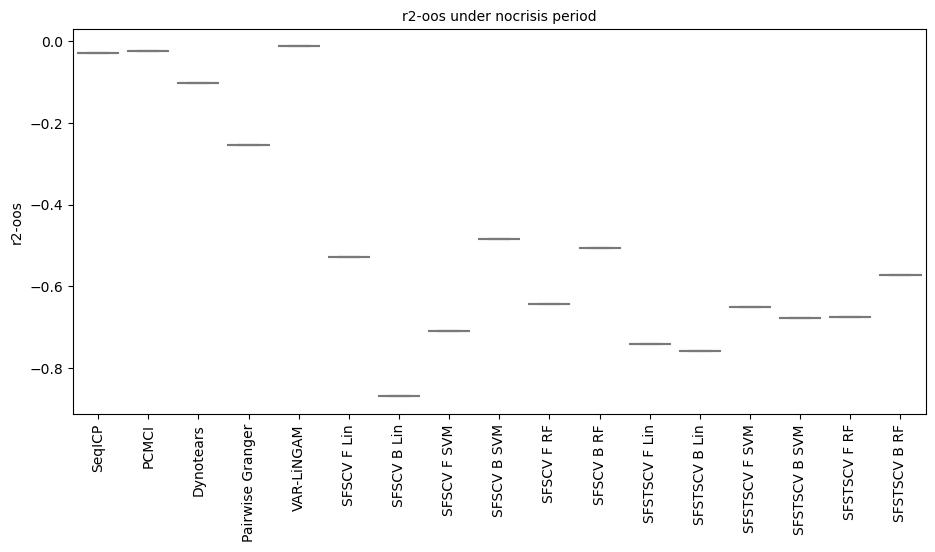

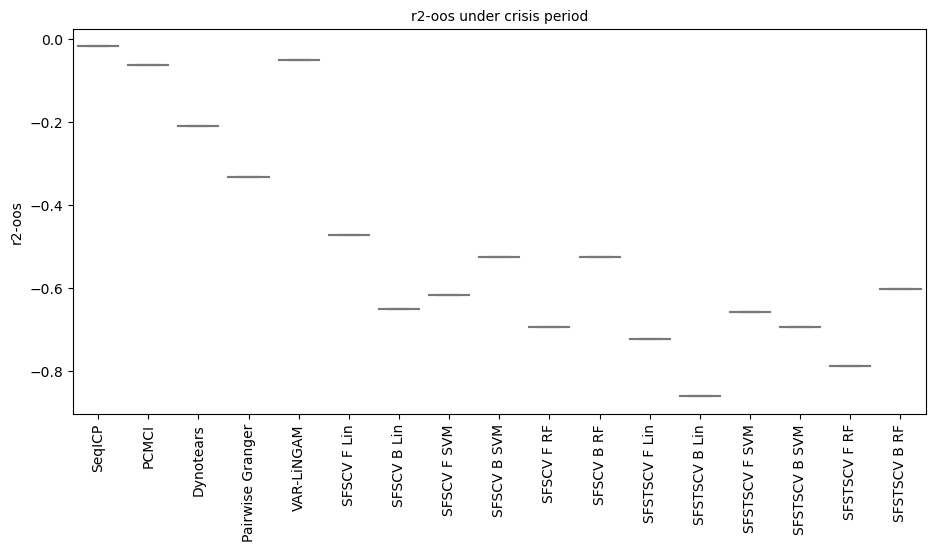

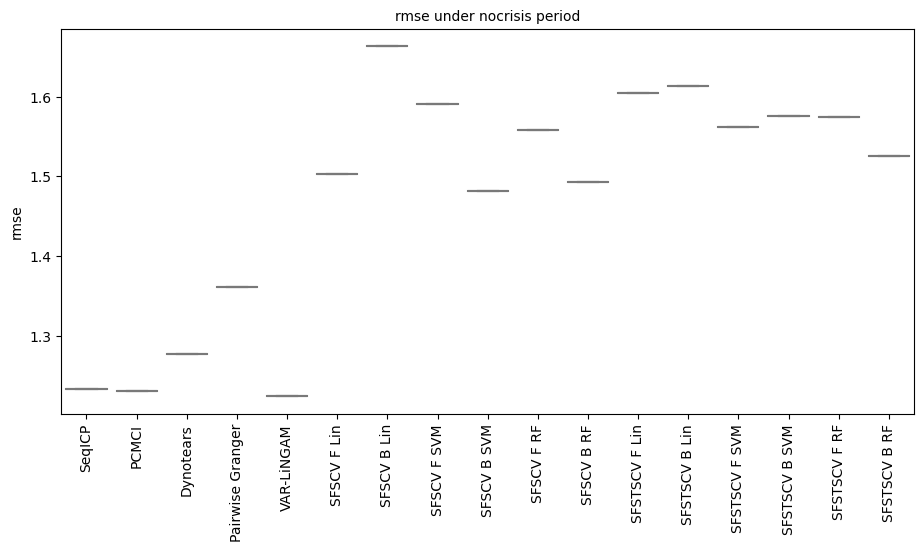

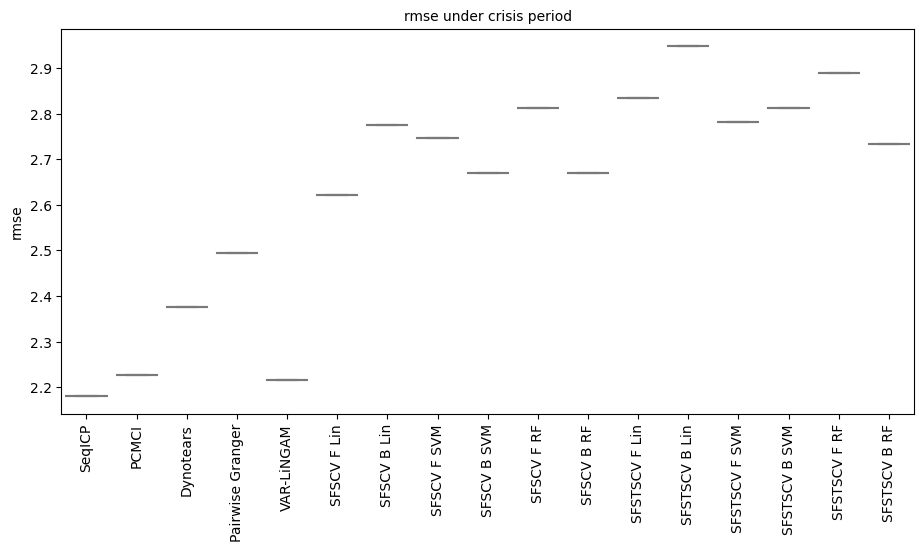

In [84]:
for m in metric_names:
    for c in melted_all_metrics_df["crisis"].unique():
        boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)&
                                               (melted_all_metrics_df["crisis"] == c)].drop(["variable"], axis=1)

        fig, ax = plt.subplots(figsize=(11, 5))
        sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
        ax.set_title(f"{m} under {c} period", fontsize=10)
        ax.set_ylabel(m, fontsize=10)
        ax.set_xlabel("", fontsize=10)
        ax.tick_params(axis="x", labelsize=10)
        ax.tick_params(axis="y", labelsize=10)
        # ax.legend(loc="best",fontsize=10)
        plt.xticks(rotation=90)
        fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_{c}_fs.png'))

## Prediction error over time

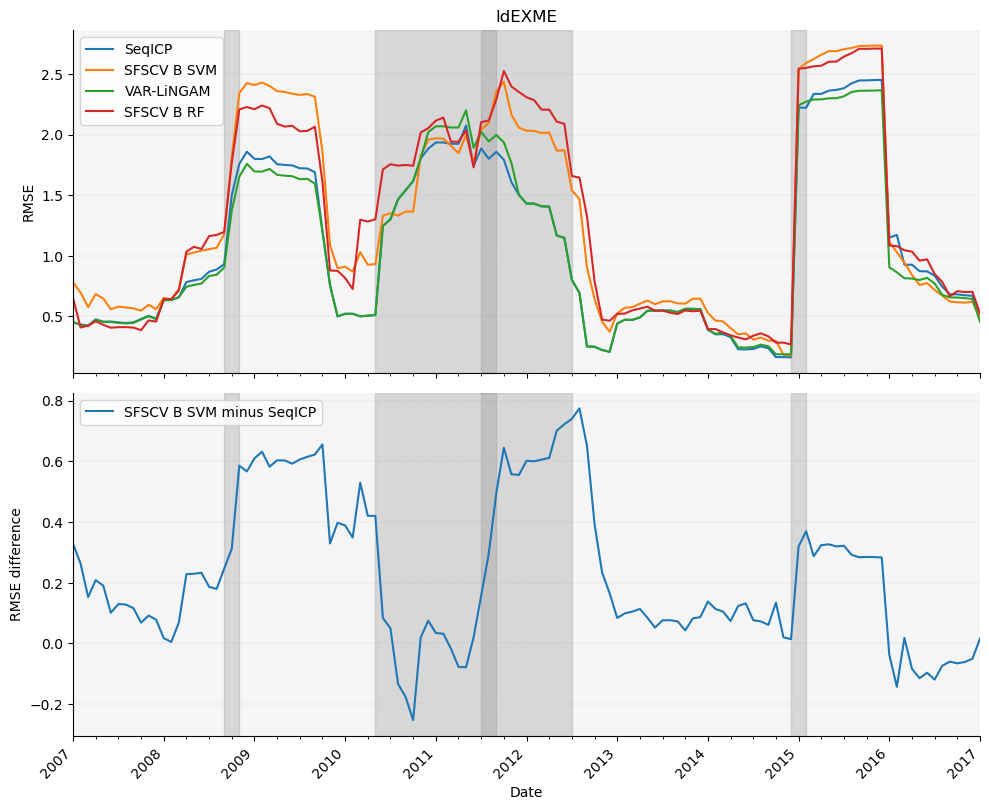

In [105]:
selected_models = ["SeqICP", "SFSCV B SVM", "VAR-LiNGAM", "SFSCV B RF"]
benchmark_name = "SFSCV B SVM"
causal_name = "SeqICP"
rolling_metric_name = "rolling_rmse"

column_name = f"{benchmark_name} minus {causal_name}"

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]==rolling_metric_name)].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df[selected_models]
    etf_rolling_metrics_df[column_name] = etf_rolling_metrics_df[benchmark_name] - etf_rolling_metrics_df[causal_name]

     # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop([column_name], axis=1).plot(ax=axs[0])
    axs[0].set_ylabel('RMSE')
    axs[0].legend(loc='upper left')
    axs[0].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[0].set_facecolor('whitesmoke')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plotting on the lower subplot
    etf_rolling_metrics_df[column_name].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('RMSE difference')
    axs[1].legend(loc='upper left')
    axs[1].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[1].set_facecolor('whitesmoke')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    # Add shaded regions for each event
    for event_name, date in event_dates:
        start_date, end_date = date[0], date[1]
        axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)
        axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)

    # Set x-ticks to yearly frequency, adjust as necessary
    tick_positions = pd.date_range(start=etf_rolling_metrics_df.index.min(), end=etf_rolling_metrics_df.index.max(), freq='AS')
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels([tp.strftime('%Y') for tp in tick_positions], rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_rmse.png'))

    axs[0].set_title(f'{etf}')

    # Show the plot
    plt.show()

## Features Heatmap

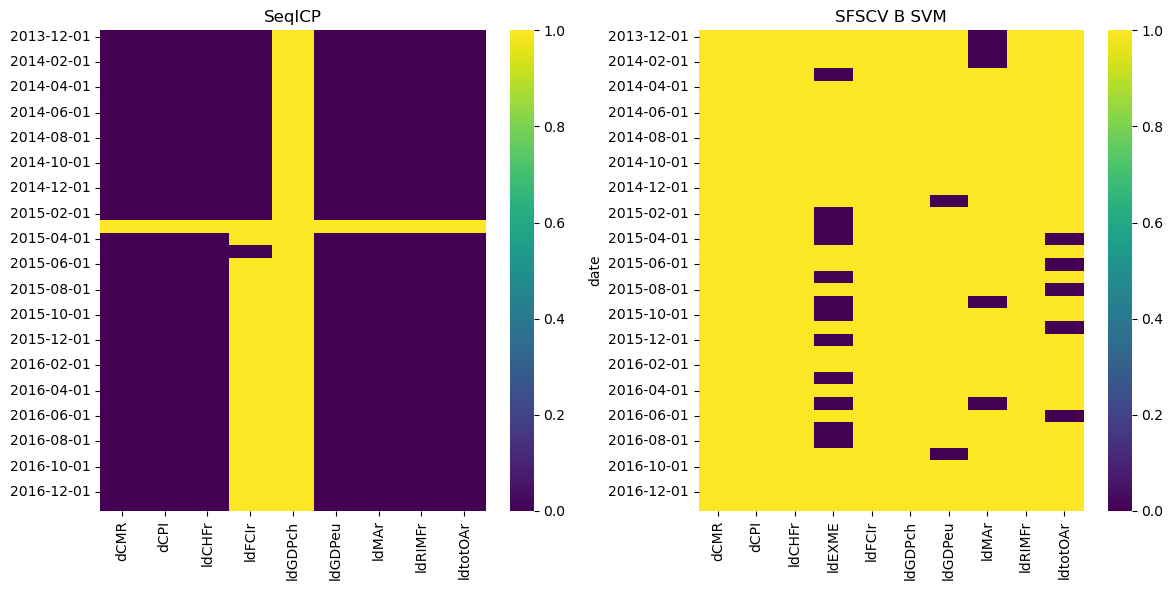

In [170]:
etf = "ldEXME"
first_fs = "seqICP_nocluster"
second_fs = "sfscv-backward-svm_nocluster"

# Create a figure with 2 subplots (side by side)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First heatmap
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf) & (all_parents_df['fs'] == first_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).fillna(0)

# # Resample
# pivot_table_data.index = pd.to_datetime(pivot_table_data.index)
# pivot_table_data = pivot_table_data.resample("M").last().fillna(0)

# Fix date index
pivot_table_data.index = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in pivot_table_data.index]

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns.name = ""

sns.heatmap(pivot_table_data, ax=axs[0], cmap="viridis")
axs[0].set_title(fs_methods_tags[first_fs])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)  # Rotate column names

selected_dates = pivot_table_data.index

# Second heatmap
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf) & (all_parents_df['fs'] == second_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).fillna(0)

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns.name = ""

pivot_table_data = pivot_table_data[(pd.to_datetime(selected_dates[0]) - relativedelta(months=0)).strftime("%Y-%m-%d"):]

sns.heatmap(pivot_table_data, ax=axs[1], cmap="viridis")
axs[1].set_title(fs_methods_tags[second_fs])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)  # Rotate column names

# Adjust layout
plt.tight_layout()

# Save plot
fig.savefig(os.path.join(results_path, f'{etf}_{fs_methods_tags[first_fs]}_compare_clusters_heatmap.png'))

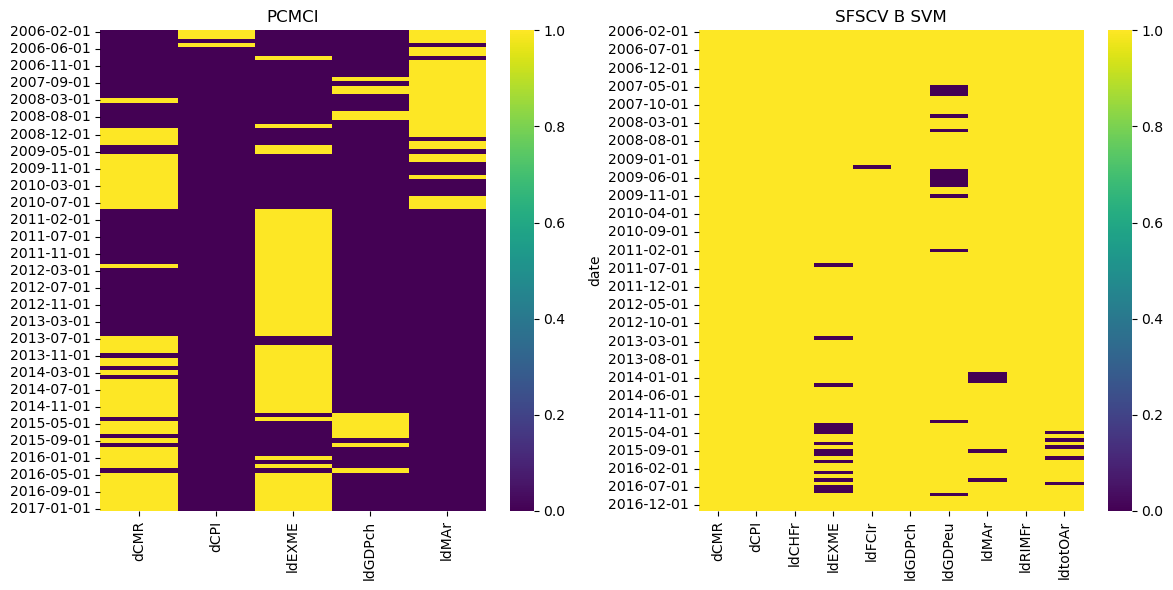

In [171]:
etf = "ldEXME"
first_fs = "pcmci_nocluster"
second_fs = "sfscv-backward-svm_nocluster"


# Create a figure with 2 subplots (side by side)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First heatmap
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf) & (all_parents_df['fs'] == first_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).fillna(0)

# # Resample
# pivot_table_data.index = pd.to_datetime(pivot_table_data.index)
# pivot_table_data = pivot_table_data.resample("M").last().fillna(0)

# Fix date index
pivot_table_data.index = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in pivot_table_data.index]

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns.name = ""

sns.heatmap(pivot_table_data, ax=axs[0], cmap="viridis")
axs[0].set_title(fs_methods_tags[first_fs])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)  # Rotate column names

selected_dates = pivot_table_data.index

# Second heatmap
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf) & (all_parents_df['fs'] == second_fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).fillna(0)

# # Resample
# pivot_table_data.index = pd.to_datetime(pivot_table_data.index)
# pivot_table_data = pivot_table_data.resample("M").last().fillna(0)

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns.name = ""

pivot_table_data = pivot_table_data[(pd.to_datetime(selected_dates[0]) - relativedelta(months=1)).strftime("%Y-%m-%d"):]

sns.heatmap(pivot_table_data, ax=axs[1], cmap="viridis")
axs[1].set_title(fs_methods_tags[second_fs])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)  # Rotate column names

# Adjust layout
plt.tight_layout()

# Save plot
fig.savefig(os.path.join(results_path, f'{etf}_{fs_methods_tags[first_fs]}_compare_clusters_heatmap.png'))

## Selected Features During Specific Periods

In [132]:
dict(event_dates)

{'GFC': ('2008-09-01', '2008-11-01'),
 'Eurozone Debt Crisis': ('2010-05-01', '2012-07-01'),
 'Swiss Franc Peg Announcement': ('2011-07-01', '2011-09-01'),
 'Swiss Franc Peg Removal': ('2014-12-01', '2015-02-01'),
 'COVID-19': ('2020-01-01', '2020-04-01')}

In [144]:
event_dates_dict = dict(event_dates)
etf = "ldEXME" # "SPY"
fs = "pcmci_nocluster"
for crisis_name in event_dates_dict.keys():

    check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
    check_df = check_df.set_index("date")

    check_df = check_df.loc[:event_dates_dict[crisis_name][0]]
    check_df = check_df.reset_index()

    print(check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).dropna(axis=1, how="all").iloc[-1].dropna())

       fred 
value  ldMAr    1.0
Name: 2008-09-01 00:00:00, dtype: float64
       fred
value  dCMR    1.0
Name: 2010-05-01 00:00:00, dtype: float64
       fred  
value  ldEXME    1.0
Name: 2011-07-01 00:00:00, dtype: float64
       fred  
value  dCMR      1.0
       ldEXME    1.0
Name: 2014-12-01 00:00:00, dtype: float64
       fred  
value  dCMR      1.0
       ldEXME    1.0
Name: 2017-01-01 00:00:00, dtype: float64


## Stability Measure

In [178]:
all_etfs_scores = []
all_avg_scores = []
for ticker in all_parents_df["etf"].unique():
    etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
    etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

    etf_df = etf_df.sort_values(by=["date"])
    all_scores = []
    for fs in etf_df["fs"].unique():
        fs_etf_df = etf_df[etf_df["fs"] == fs]

        score = []
        for i, date in enumerate(fs_etf_df["date"].unique()):
            if i == 0:
                F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = 0
            else:
                F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
                F_tm1 = copy(F_t)
            score.append({"date": date, "score": s})
        score_df = pd.DataFrame(score)
        score_df["fs"] = fs_methods_tags[fs]

        melt_score_df = score_df.melt(["date", "fs"])
        all_scores.append(melt_score_df)
    all_scores_df = pd.concat(all_scores).drop("variable", axis=1)
    all_scores_df["etf"] = ticker
    all_etfs_scores.append(all_scores_df)

    avg_scores = all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False).reset_index()
    avg_scores['ticker'] = ticker
    avg_scores = avg_scores[['ticker', 'fs', 'value']]
    all_avg_scores.append(avg_scores)
all_avg_scores_df = pd.concat(all_avg_scores)
all_etfs_scores_df = pd.concat(all_etfs_scores)

In [179]:
all_etfs_scores_df.groupby("fs").mean()[["value"]].round(3).sort_values('value', ascending=False)

,value
fs,
SFSCV F Lin,0.952
SFSCV B SVM,0.951
SFSTSCV B SVM,0.948
SFSTSCV B Lin,0.946
SFSCV B Lin,0.944
SFSCV B RF,0.944
SFSCV F SVM,0.943
SFSCV F RF,0.939
SFSTSCV F RF,0.936


<Axes: xlabel='date'>

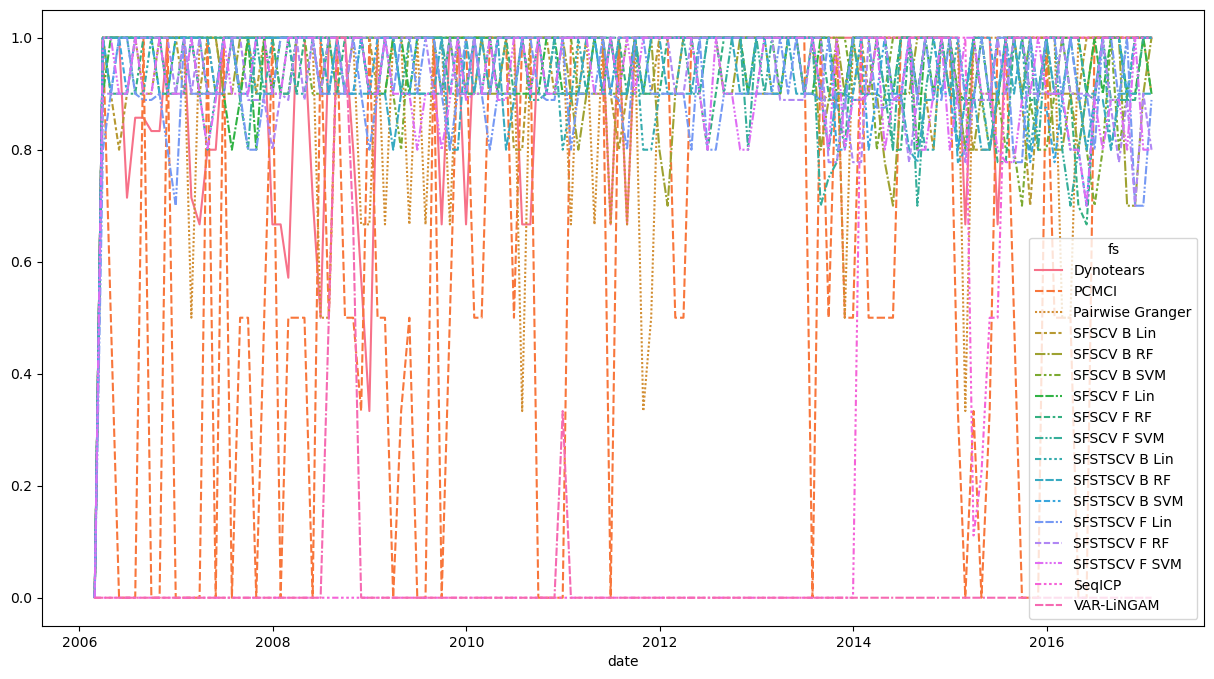

In [180]:
pivot_all_etfs_scores_df = all_etfs_scores_df.pivot_table(index=["date"], columns=["fs"], values=["value"])
pivot_all_etfs_scores_df.columns = pivot_all_etfs_scores_df.columns.droplevel(0)
pivot_all_etfs_scores_df.index = pd.to_datetime(pivot_all_etfs_scores_df.index)
pivot_all_etfs_scores_df = pivot_all_etfs_scores_df.resample("M").last().fillna(0)

plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_all_etfs_scores_df)